## Canny算子

### 好的边缘检测算子应具有的三个指标：

1. 低失误概率：既要少将真正的边缘丢失也要少将非边缘判为边缘。
2. 高位置精度：检测出的边缘应在真正的边界上。
3. 对每个边缘有唯一的响应：得到的边界为单像素。（NMS）

### 要点

* 高斯平滑
* Sobel边缘检测（或其它边缘检测算子）
* 非极大值抑制（Non-maximal suppression,NMS）
* 滞后阈值化（Hysteresis thresholding）

### 具体步骤

1. 使用高斯滤波器平滑图像以减轻噪声影响。大的模板会较多地模糊图像，但可检测出数量较少但更为突出的边缘。
2. 检测滤波图像中灰度梯度的大小和方向。（e.g. Sobel）
3. 细化边界。采用非极大值抑制方法（NMS），考虑梯度幅度图中的小邻域（e.g. 3x3），并在其中比较中心像素与其梯度方向上的相邻像素来实现。如中心像素小于梯度方向的相邻像素值，就将其置0。否则将其保留。
4. 选取两个阈值并借助滞后阈值化方法最后确定边缘点。首先标记**边缘像素的梯度值>高阈值**，作为种子点，这些点肯定为边缘，然后再标记**低阈值<梯度值<高阈值且与种子点邻接**的像素点。这些被标记点最终构成图像边缘。

### 参考
* [Canny, J., A Computational Approach To Edge Detection, IEEE Trans. Pattern Analysis and Machine Intelligence, 8:679-714, 1986](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4767851&tag=1)
* https://zhuanlan.zhihu.com/p/33676923
* [Scikit image: Canny edge detector](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html?highlight=canny)
* [Scikit image: Canny API](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=canny#skimage.feature.canny)
* [Canny edge detection in Python OpenCV](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html)
* [Canny edge detection in c++ OpenCV](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

### 实现

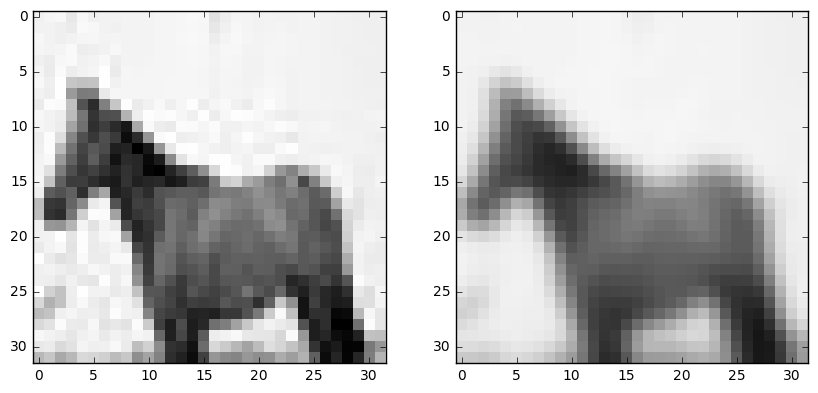

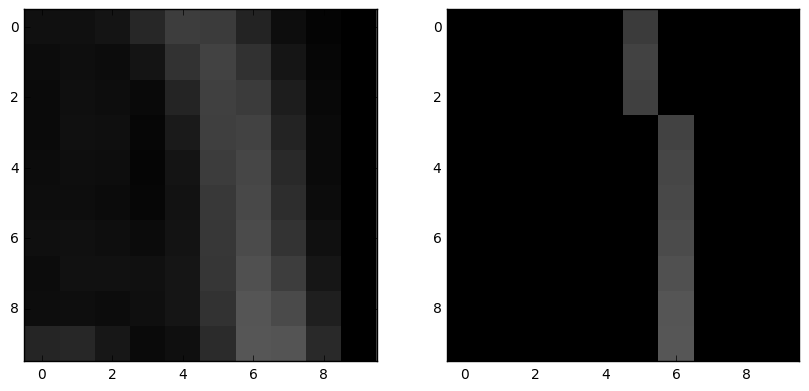

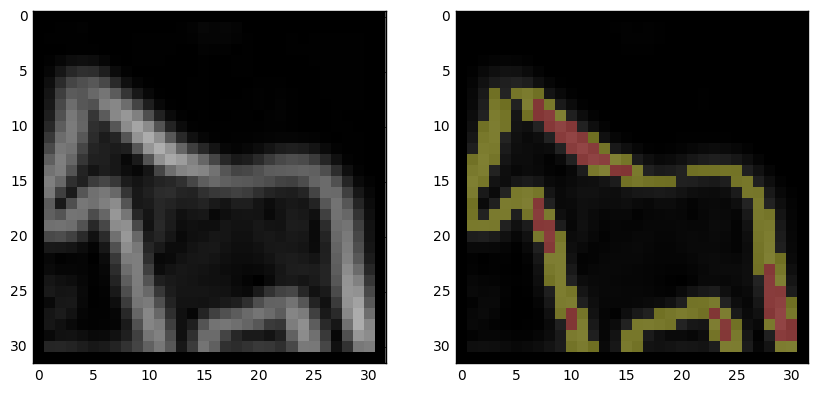

In [35]:
import skimage.filters as filters
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skdemo
from skimage import color
from skimage import img_as_float

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

# 读入图像
image = io.imread('7_216.jpg', as_grey=True)
image = img_as_float(image)

# 第1步，高斯平滑
sigma = 1  # Standard-deviation of Gaussian; larger smooths more.
smooth = filters.gaussian(image, sigma)

# 第2步，Sobel边缘检测
gradient_magnitude = filters.sobel(smooth)

# 第3步，非极大值抑制（演示）
zoomed_grad = gradient_magnitude[16:26, 22:32]
maximal_mask = np.zeros_like(zoomed_grad)
# This mask is made up for demo purposes
maximal_mask[range(10), (5, 5, 5, 6, 6, 6, 6, 6, 6, 6)] = 1
grad_along_edge = maximal_mask * zoomed_grad

# 第4步，滞后阈值化
# Goal: Prefer pixels that are connected to edges
low_threshold = 0.2
high_threshold = 0.3
label_image = np.zeros_like(image)
label_image[gradient_magnitude > low_threshold] = 1
label_image[gradient_magnitude > high_threshold] = 2
# This uses `gradient_magnitude` which has NOT gone through non-maximal-suppression.

demo_image = color.label2rgb(label_image, gradient_magnitude,
                             bg_label=0, colors=('yellow', 'red'))

# 显示
skdemo.imshow_all(image, smooth)
skdemo.imshow_all(zoomed_grad, grad_along_edge, limits='dtype')
skdemo.imshow_all(gradient_magnitude, demo_image)



plt.show()

**红色像素点**为大于高阈值的种子点。**黄色像素点**为梯度大于低阈值且与红色像素点邻接的点。红色与黄色像素共同构成边缘像素。该方法可减弱噪声在最终边缘图像中的影响，并可避免产生由于阈值过低导致的虚假边缘或由于阈值过高导致的边缘丢失。

### Python API

In [68]:
# skimage.feature.canny(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False)

#### Parameters:	
* **image** : 2D array
Greyscale input image to detect edges on; can be of any dtype.
* **sigma** : float
Standard deviation of the Gaussian filter.
* **low_threshold** : float
Lower bound for hysteresis thresholding (linking edges). If None, low_threshold is set to 10% of dtype’s max.
* **high_threshold** : float
Upper bound for hysteresis thresholding (linking edges). If None, high_threshold is set to 20% of dtype’s max.
* **mask** : array, dtype=bool, optional
Mask to limit the application of Canny to a certain area.
* **use_quantiles** : bool, optional
If True then treat low_threshold and high_threshold as quantiles of the edge magnitude image, rather than absolute edge magnitude values. If True then the thresholds must be in the range [0, 1].

#### Returns:	
* **output** : 2D array (image)
The binary edge map.

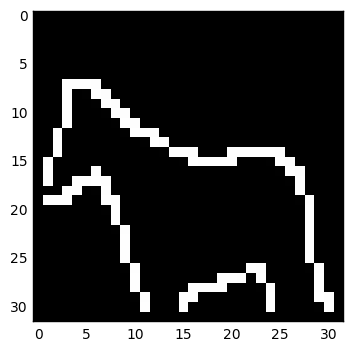

In [69]:
from skimage import feature

edges = feature.canny(image, sigma=1.0, low_threshold=0.4, high_threshold=0.7, mask=None, use_quantiles=False)

plt.imshow(edges)
plt.show()